# ML Pipeline for the CC dataset

## Purpose of this notebook
- [x]  Prepare dataframe for ML
- [x]  Create baseline models
    - [x]  User-based
        - [x]  last known assessment *of this user*
        - [x]  all known assessments *of this user*
    - [x]  Assessment-based
        - [x]  last known assessment
        - [x]  all assessments
- [x]  Perform different split approaches to get different model solutions
    - [x]  Answer-Cut
    - [x]  Time-Cut
    - [x]  User-wise
    - [x]  Average-user
- [x]  Evalulate all approaches in one table in terms of performance and robustness
- [ ] Review approaches

## Prepare dataframe for ML

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier

# to import own modules, a workaround - assuming the curent working directory is the folder (your/local/path/UsAs/src/d01_analysis
import sys
sys.path.insert(0, "../..")

from src.d00_utils import helpers, process_ch_stress_dataset

In [2]:
# suppress annoying warnings
pd.options.mode.chained_assignment = None

In [3]:
# read in df
df = pd.read_csv('../../data/d02_processed/ch_stress.csv')
df.set_index('answer_id', inplace=True)

In [4]:
df.head()

,user_id,created_at,pss1,pss2,pss3,pss4,pss5,pss6,pss7,pss8,pss9,pss10,pss10_t1
answer_id,,,,,,,,,,,,,
11583,4182,2020-12-19 07:59:15,2,3,2,3,2,2,2,2,2,2,2.0
11781,4749,2020-12-22 05:21:24,2,3,4,2,2,3,2,2,4,2,3.0
11859,4818,2020-12-23 09:34:44,0,4,1,4,4,0,4,4,1,0,0.0
11905,4749,2020-12-24 05:02:52,2,2,4,2,2,3,2,2,4,3,2.0
11918,4805,2020-12-24 08:25:25,1,1,2,3,2,3,1,2,3,2,2.0


Define test data to evaluate all approaches on the same testset.

20 % of the users shall be taken for test, 80 % for trying out different approaches.

In [5]:
df.describe()

,user_id,pss1,pss2,pss3,pss4,pss5,pss6,pss7,pss8,pss9,pss10,pss10_t1
count,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000
mean,5377.045520,1.396716,1.614808,1.978680,2.463267,2.113224,1.828003,2.075194,2.211755,1.917027,1.489484,1.497551
std,2600.144615,1.152459,1.265594,1.216413,1.103448,1.046815,1.281246,1.075985,1.128024,1.202795,1.360133,1.363346
min,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3903.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,5284.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000
75%,6843.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,11421.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [6]:
# first 80 % of users into train, second 20 % into test
df_train, df_test = helpers.create_train_and_test_set(df)

In [7]:
# define features and target
features = process_ch_stress_dataset.get_features()
target = 'pss10_t1'
time_col = 'created_at'
user_col = 'user_id'

# set up for classification - target is already categorical, no bins or LabelEncoding required
bins = None
LE = None

# preare dataset and model
model, X_train, X_test, y_train, y_test, _ = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=False, cut=False)

# Create mapping
mapping = { 0:    'Never',
            1:    'Almost never',
            2:    'Sometimes',
            3:    'Fairly often',
            4:    'Very often'
            }

# cross validation setup
n_splits = 5
test_size = 1/n_splits

# preprare results dic
approaches = ['bl_user_based_last', 'bl_user_based_all', 'bl_assessment_based_last', 'bl_assessment_based_all',
             'answer_cut', 'time_cut', 'user_wise', 'average_user']
results_dic = {approach: {'f1':None, 'std':None} for approach in approaches}

# create a random_state
random_state = 1994

## Create baseline models

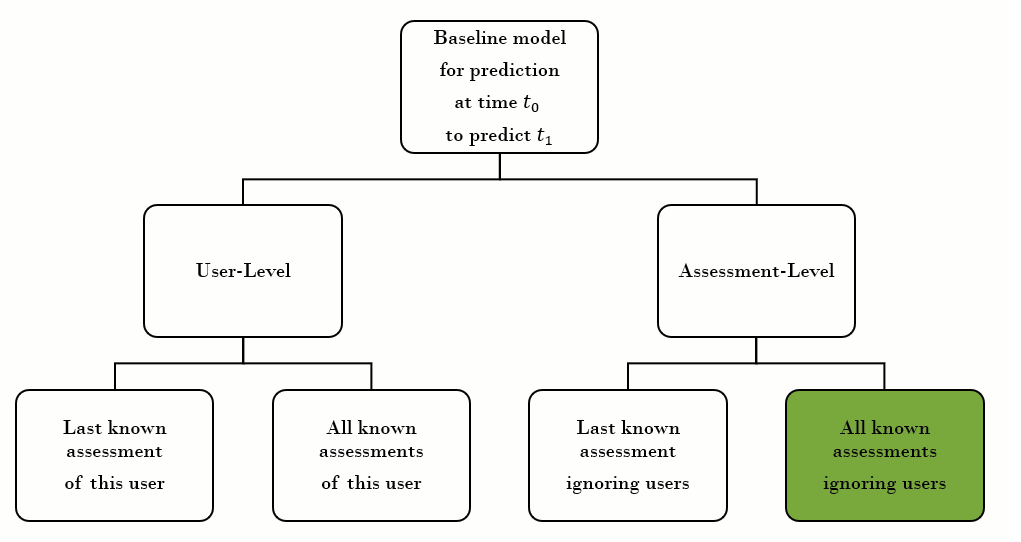

Approach:	 all
0.0    190
1.0    139
2.0    116
3.0     80
4.0     67
Name: pss10_t1, dtype: int64
0.0    190
1.0    142
2.0    115
3.0     77
4.0     68
Name: pss10_t1, dtype: int64
0.0    199
1.0    149
2.0    105
3.0     85
4.0     54
Name: pss10_t1, dtype: int64
0.0    208
1.0    160
2.0     95
3.0     73
4.0     56
Name: pss10_t1, dtype: int64
0.0    189
1.0    169
2.0     89
3.0     73
4.0     72
Name: pss10_t1, dtype: int64
Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.1767809058581109
standarddeviation 	 0.01811149397344204
#################################################
User approach
f1_weighted mean 	 0.5944519741316503
standarddeviation 	 0.01626224689557219
Performance within TEST
Final score assessment approach:	 0.1384547166840492


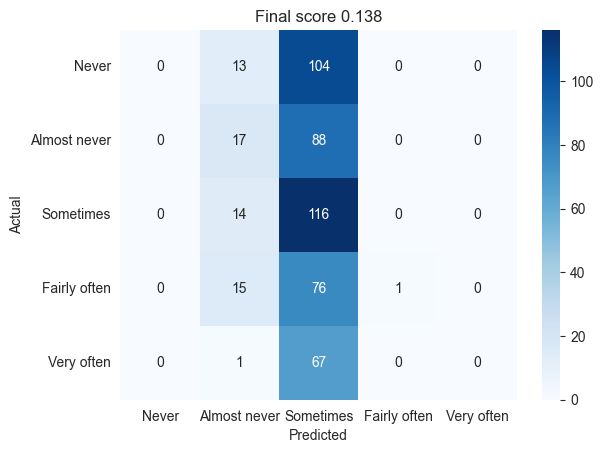

Final score user approach:	 0.5575918312206232


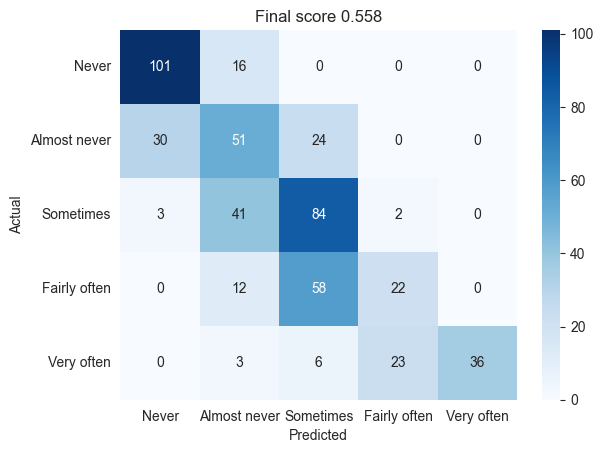

Approach:	 last
0.0    190
1.0    139
2.0    116
3.0     80
4.0     67
Name: pss10_t1, dtype: int64
0.0    190
1.0    142
2.0    115
3.0     77
4.0     68
Name: pss10_t1, dtype: int64
0.0    199
1.0    149
2.0    105
3.0     85
4.0     54
Name: pss10_t1, dtype: int64
0.0    208
1.0    160
2.0     95
3.0     73
4.0     56
Name: pss10_t1, dtype: int64
0.0    189
1.0    169
2.0     89
3.0     73
4.0     72
Name: pss10_t1, dtype: int64
Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.24549304051966195
standarddeviation 	 0.004066703004877077
#################################################
User approach
f1_weighted mean 	 0.4812762129877335
standarddeviation 	 0.008464256953737113
Performance within TEST
Final score assessment approach:	 0.27340731162674436


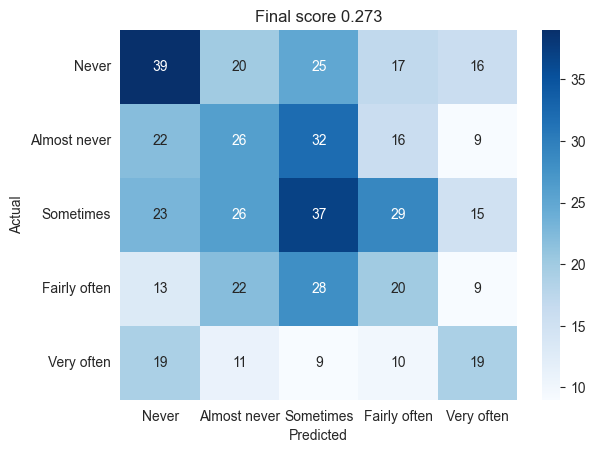

Final score user approach:	 0.5666639065698035


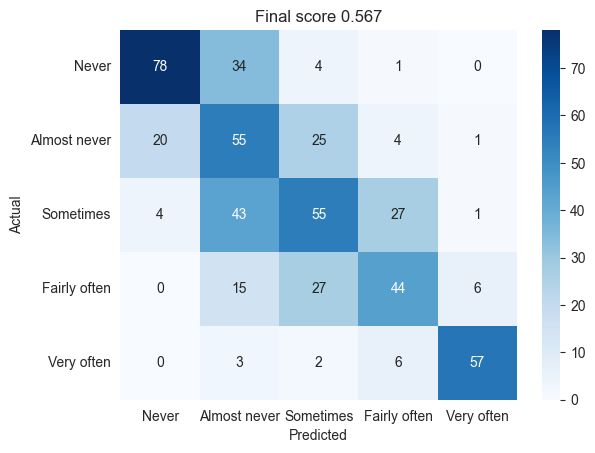

In [9]:
# instantiate model
model = helpers.baseline_model()

# define constants
for approach in ['all', 'last']:
    print('Approach:\t', approach)

    # train model in cross validation
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores_a = []
    scores_u = []
    for _, val_indices in cv.split(df_train):

        # divide all train data into folds
        df_train_val_fold = df_train.iloc[val_indices, :]

        # get baseline prediction
        y_pred_a = model.get_baseline_assessment_prediction(data=df_train_val_fold, target_name=target, 
                                                            approach=approach, time_col = time_col, mode=True)
        y_pred_u = model.get_baseline_user_prediction(data=df_train_val_fold, target_name=target, 
                                                      approach=approach, time_col = time_col, mode=True)
        y_true = df_train_val_fold[target]

        assert y_pred_a.shape[0] == y_true.shape[0]
        print(y_true.value_counts(dropna=False))

        # calculate score
        f1_score_test_a = f1_score(y_true, y_pred_a, average='weighted')
        f1_score_test_u = f1_score(y_true, y_pred_u, average='weighted')
        scores_a.append(f1_score_test_a)
        scores_u.append(f1_score_test_u)

    # validate model
    print('Performance within TRAIN')
    print('Assessment approach')
    print('f1_weighted mean \t', np.array(scores_a).mean())
    print('standarddeviation \t', np.array(scores_a).std())
    print('#################################################')
    print('User approach')
    print('f1_weighted mean \t', np.array(scores_u).mean())
    print('standarddeviation \t', np.array(scores_u).std())
    # evaluate on test set

    # assessment------------------------------------------------------------------------------
    y_pred_a = model.get_baseline_assessment_prediction(data=df_test, target_name=target, 
                                                        approach=approach, mode=True).values

    f1_score_test_a = f1_score(y_test, y_pred_a, average='weighted')
    std = np.array(scores_a).std()
    final_score_a = f1_score_test_a - 0.5 * std

    print('Performance within TEST')
    print('Final score assessment approach:\t', final_score_a)
    
    results_dic[f'bl_assessment_based_{approach}']['f1'] = final_score_a
    results_dic[f'bl_assessment_based_{approach}']['std'] = std



    # visualize confusion matrix
    # assessment
    helpers.visualize_confusion_matrix(y_test, y_pred_a, mapping, final_score_a)

    # user------------------------------------------------------------------------------------

    y_pred_u = model.get_baseline_user_prediction(data=df_test, target_name=target, approach=approach).values
    f1_score_test_u = f1_score(y_test, y_pred_u, average='weighted')
    std = np.array(scores_u).std()
    final_score_u = f1_score_test_u - 0.5 * std
    
    results_dic[f'bl_user_based_{approach}']['f1'] = final_score_u
    results_dic[f'bl_user_based_{approach}']['std'] = std

    print('Final score user approach:\t', final_score_u)



    helpers.visualize_confusion_matrix(y_test, y_pred_u, mapping, final_score_u)

#### Assessment approach
 - `last`: #TODO interpret
 - `all`:  #TODO interpret
 
#### User approach
 - `last`: #TODO interpret
 - `all`:  #TODO interpret

## Perform different split approaches to get different model solutions

### Approach | Assessment | Answer-cut

Performance within train
f1_weighted mean  0.5746566029191549
standarddeviation  0.012902419742930141


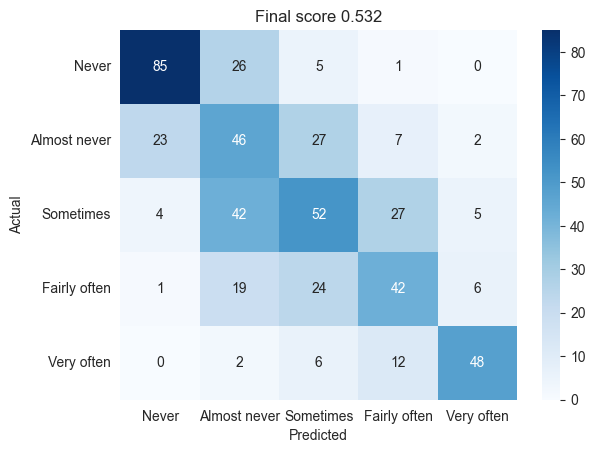

In [10]:
# instantiate model
model = RandomForestClassifier(random_state=random_state)

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'answer_cut'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['std'] = scores.std()

With the standard random shuffle and ignoring user aspects, the model is better than random guessing. However, without having the information that user groups exist, the score is well below 60 %.

### Approach | Assessment | Time-cut

Performance within train
f1_weighted mean  0.542
standarddeviation  0.021


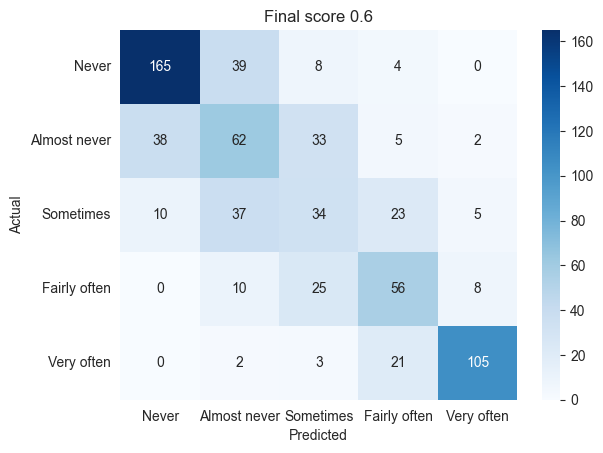

In [11]:
# 80 % of first data by time into train, 20 % into test
row80 = int(df.shape[0]*0.8)
df_train = df.sort_values(by=time_col).iloc[:row80, :]
df_test = df.sort_values(by=time_col).iloc[row80:, :]

model, X_train, X_test, y_train, y_test, LE = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=False, cut=False)

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
groups = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', round(scores.mean(), 3))
print('standarddeviation ', round(scores.std(), 3))

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'time_cut'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['std'] = scores.std()

Making a precise differentiation with evenly sized time chunks, the model improves to the random approach. This might be due to the fact that some users joined the study later, so there was an indirect grouped kfold validation. The score improves from the random approach by 3%-points.

### Approach | User | Average-user

For each assesment, check the user id and calculate the mean of all answers known by this user so far. These mean replace the reported assessments.

Performance within train
f1_weighted mean  0.6068825275142442
standarddeviation  0.0188609834996052


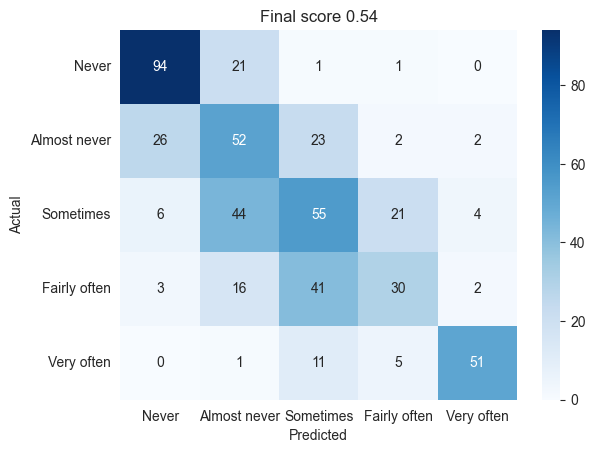

In [12]:
# get original train and test users
df_train, df_test = helpers.create_train_and_test_set(df)

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
groups = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# calculate grouped cumulative means for all assessments of all users
df_train_avg_user = helpers.calc_cum_mean(df_train, features, user_id='user_id')
df_test_avg_user = helpers.calc_cum_mean(df_test, features, user_id='user_id')

# prepare data and model
model, X_train, X_test, y_train, y_test, LE = helpers.prepare_and_instantiate(df_train_avg_user, df_test_avg_user, features, target, bins, LE, fit=False, cut=False)

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# fit and calculate
y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'average_user'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['std'] = scores.std()

The model overfits on the users from the train set. The drop from train to test is 9%-points. The between-fold variance is low with less than 1%.
The answer behavior of users from the train set differs to those from the test set - that could be a reason for the high performance drop.

## Approach | User | User-wise-model

In [13]:
user_dfs = helpers.create_user_dfs(df_test, min_assessments=10)

mean within train for per user: 0.5460876255264011
std within train for per user: 0.3445564233466604


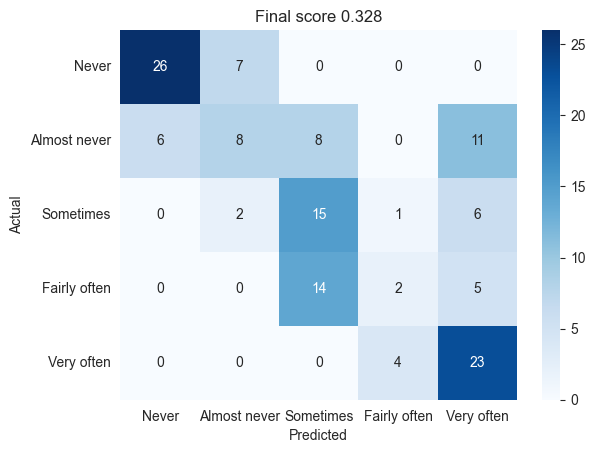

In [14]:
y_preds, y_tests, all_scores, all_f1s_final, n_assessments_training= [], [], [], [], []


for i, user_df in enumerate(user_dfs):
    
    # sort by assessment
    user_df = user_df.sort_values(by=time_col)
    
    # create train and test assessments
    # 60 % position idx
    idx60 = int("{:.0f}".format(user_df.shape[0]*.6))
    train_assessments = user_df.iloc[:idx60, :]
    test_assessments  = user_df.iloc[idx60:, :]
    # preare dataset and model
    model, X_train, X_test, y_train, y_test, LE = helpers.prepare_and_instantiate(train_assessments, test_assessments, features, target, bins, LE, fit=False, cut=False)
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

    # fit and calculate
    y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

    all_f1s_final.append(f1_final)
    all_scores.extend(scores)
    y_tests.extend(y_test)
    y_preds.extend(y_pred)

# calculate final score
_, f1_final = helpers.calc_final_score(np.array(all_scores), y_preds, y_tests)

# print results
print('mean within train for per user:', np.array(all_scores).mean())
print('std within train for per user:', np.array(all_scores).std())

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_tests, y_preds, mapping, f1_final)    

# write to results dict
approach = 'user_wise'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['std'] = scores.std()

## Evalulate all approaches in one table in terms of performance and robustness

In [15]:
res_df = pd.DataFrame.from_dict(results_dic, orient="index").sort_values(by='f1')
res_df


,f1,std
bl_assessment_based_all,0.138455,0.018111
bl_assessment_based_last,0.273407,0.004067
user_wise,0.327818,0.232311
answer_cut,0.531515,0.012902
average_user,0.539524,0.018861
bl_user_based_all,0.557592,0.016262
bl_user_based_last,0.566664,0.008464
time_cut,0.599512,0.020796
